# Exploratory Data Analysis: Greenhouse Gases  
**Data Source**: Processed NOAA data (cleaned in `1_data_loading.ipynb`)  

## Key Notes  
- **Focus Gas**: CH₄ (Methane) - primary analysis target  
- **Data Quality**:  
  - Missing values: All rows kept (missing values → `NaN`)  
  - Negative values: Converted to `NaN` (non-physical concentrations)  
  - Data start dates: Gases have distinct collection start dates  
- Raw data pipeline documented in [`1_data_loading.ipynb`](../notebooks/1_data_loading.ipynb)  

## Data Files  
- **Input**: `../data/processed/all_ghg_aligned.csv`  
- **Output**: `../data/processed/all_ghg_aligned_nan.csv`  

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from pathlib import Path
import os
from statsmodels.tsa.stattools import adfuller, kpss

# Make Directory

In [2]:
# automatic path handling
NOTEBOOK_PATH = Path.cwd() # gets current working directory
if 'notebooks' in str(NOTEBOOK_PATH): # if running from /notebooks/
    PROCESSED_DATA = NOTEBOOK_PATH.parent / 'data' / 'processed'
else: # if running from the repo root
    PROCESSED_DATA = NOTEBOOK_PATH / 'data' / 'processed'

# create folder (if necessary)
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)

# Load Data

In [3]:
df_combined = pd.read_csv("../data/processed/all_ghg_aligned.csv", parse_dates=['date'])

In [4]:
df_combined.head()

,date,CH4,CO,CO2,H2,N2O,SF6
0,1969-08-20,NaN,NaN,-5.2700,NaN,NaN,NaN
1,1969-08-27,NaN,NaN,-2.1625,NaN,NaN,NaN
2,1969-09-02,NaN,NaN,-9.1150,NaN,NaN,NaN
3,1969-09-12,NaN,NaN,320.9450,NaN,NaN,NaN
4,1969-09-24,NaN,NaN,320.8900,NaN,NaN,NaN


# EDA 

## Data Info

In [5]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2562 non-null   datetime64[ns]
 1   CH4     2123 non-null   float64       
 2   CO      1825 non-null   float64       
 3   CO2     2553 non-null   float64       
 4   H2      790 non-null    float64       
 5   N2O     1490 non-null   float64       
 6   SF6     1488 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 140.2 KB


## Valid Data Ranges per Gas

In [6]:
# overall range of DataFrame
date_min = df_combined['date'].min()
date_max = df_combined['date'].max()
print(f'Overall date range of DataFrame: {date_min.date()} - {date_max.date()}')

# date range for each gas
gas_ranges = {}
for gas in df_combined.columns.drop('date'):
    valid_dates = df_combined.loc[df_combined[gas].notna(), 'date']
    if not valid_dates.empty:
        gas_ranges[gas] = (valid_dates.min().date(), valid_dates.max().date())
    else:
        gas_ranges[gas] = (None, None)

for gas, (start, end) in gas_ranges.items():
    print(f'{gas}: {start} - {end}')
    

Overall date range of DataFrame: 1969-08-20 - 2025-04-03
CH4: 1983-05-06 - 2024-12-31
CO: 1989-07-07 - 2025-04-03
CO2: 1969-08-20 - 2024-12-31
H2: 2009-10-20 - 2025-04-03
N2O: 1995-12-15 - 2024-12-31
SF6: 1995-12-15 - 2024-12-31


## Null and Fill Values

In [7]:
# There are two classes of null values to be concerned with:
# - null values at the beginning of a series are likely due to the different data collection start dates for each gas type
# - internal null values are null/missing values after the data collection start date for the particular gas.  These null values 
# likely need to be imputed.  

df_combined.isnull().sum()

date       0
CH4      439
CO       737
CO2        9
H2      1772
N2O     1072
SF6     1074
dtype: int64

In [8]:
# the fill values for 'values' is -999.999.  This is essentially the same as a null value.  
# So, I will check on the number of fill values.  

fillvalue_counts = (df_combined == -999.99).sum()
fillvalue_counts

date    0
CH4     0
CO      1
CO2     0
H2      0
N2O     0
SF6     0
dtype: int64

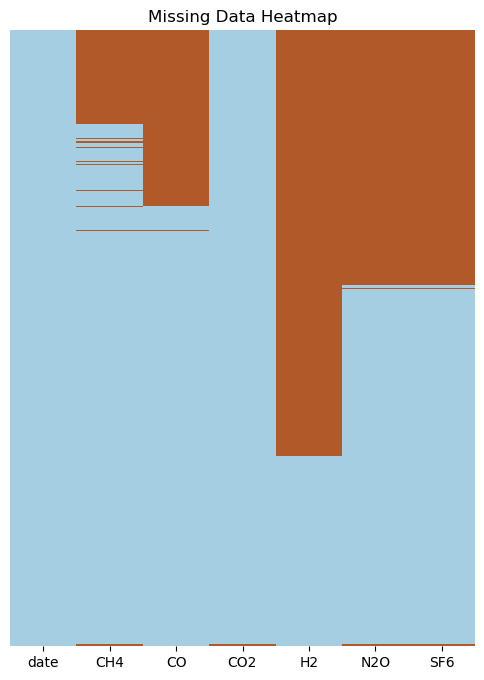

In [9]:
# visualize location of null values for each feature

plt.figure(figsize=(6,8))
sns.heatmap(df_combined.isnull(), cmap='Paired', cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

Null (NaN) values are data points that were not collected or recorded. Many null values occur at the beginning of the timeseries for each gas, except CO2, since measurement of the other gases began after the first CO2 measurement. There also appears to be null values at the end of some of the data sets.  

measurement start dates:
- CO2: 1969-8-20
- CH4: 1983-5-6
- CO: 1989-7-7
- N2O: 1995-12-15
- SF6: 1995-12-15

I will not impute any null value that exist at dates earlier than the first measurement date for each gas.

## Negative Values

In [10]:
# There are some negative values for gas concentration.  This doesn't make physical sense. 
# One possible explanation is that the GC sensor was zeroed incorrectly. Either way, I will 
# likely set them to NaN.  First, inspect:

neg_value_count = (df_combined.iloc[:,1:] < 0).sum()
print('----- Negative Value Count per Gas Type -----')
print(neg_value_count)

----- Negative Value Count per Gas Type -----
CH4     1
CO     10
CO2    16
H2      0
N2O     0
SF6     7
dtype: int64


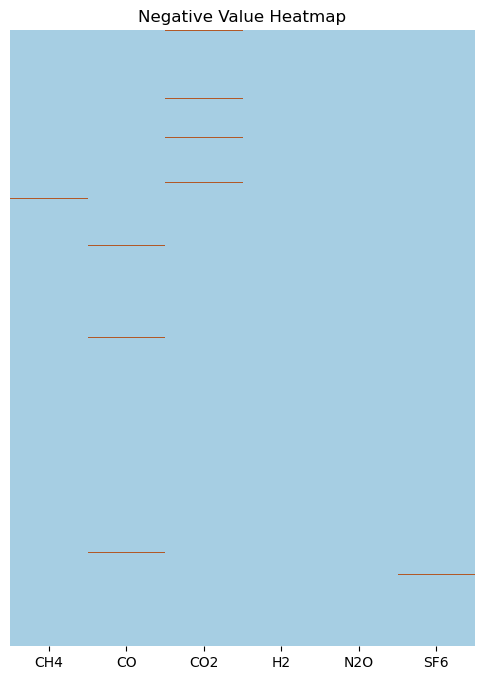

In [11]:
# visualize the location of the negative values

plt.figure(figsize=(6,8))
sns.heatmap(df_combined.iloc[:,1:] < 0, cmap='Paired', cbar=False, yticklabels=False)
plt.title('Negative Value Heatmap')
plt.show()

Negative concentration of any molecule is not physically meaningfull here. Negative values are assumed to be due to instrumentation/data collection processing errors.  

All negative values will be converted to NaN and imputed during preprocessing.  

## Store New Dateframe as CSV

In [12]:
# save the preprocessed data to the processed data folder

print(f'Processed data will save to: {PROCESSED_DATA}')
df_combined.to_csv(PROCESSED_DATA / 'all_ghg_aligned_nan.csv', index=False)

Processed data will save to: C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\data\processed


## Visualize Full Data Series and Run Stationarity Tests

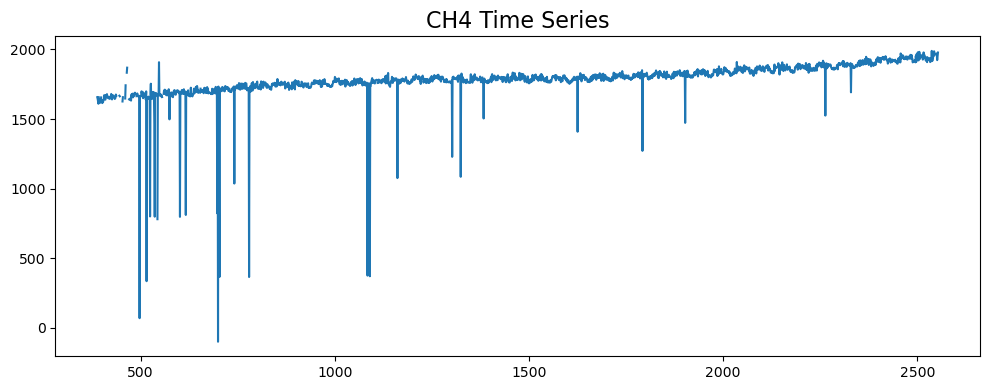

ADF and KPSS tests for CH4:
ADF statistic -2.4947
ADF p-value 0.1168
ADF critical values: {'1%': -3.4334722331103045, '5%': -2.86291926951847, '10%': -2.5675042582416148}

KPSS statistic 6.6138
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the CH4 time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_61996\1062959689.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


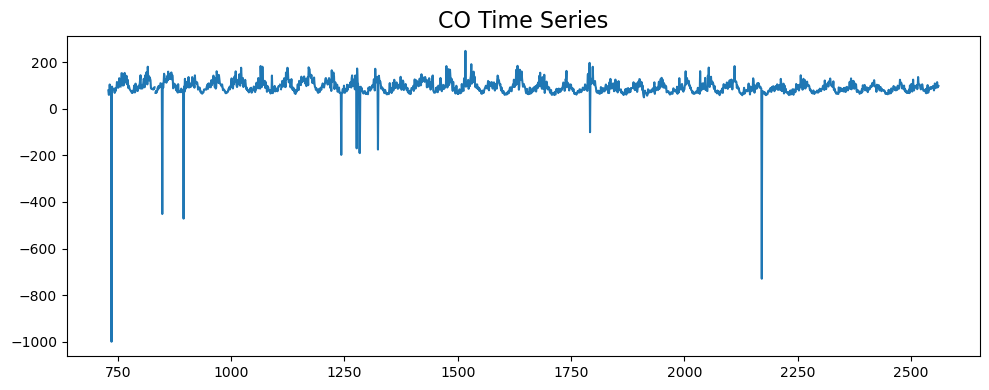

ADF and KPSS tests for CO:
ADF statistic -10.5814
ADF p-value 0.0000
ADF critical values: {'1%': -3.4339800605797155, '5%': -2.8631434696839992, '10%': -2.5676236347535166}

KPSS statistic 0.5063
KPSS p-value 0.0403
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the CO time series may be difference-stationary according to ADF and KPSS tests.



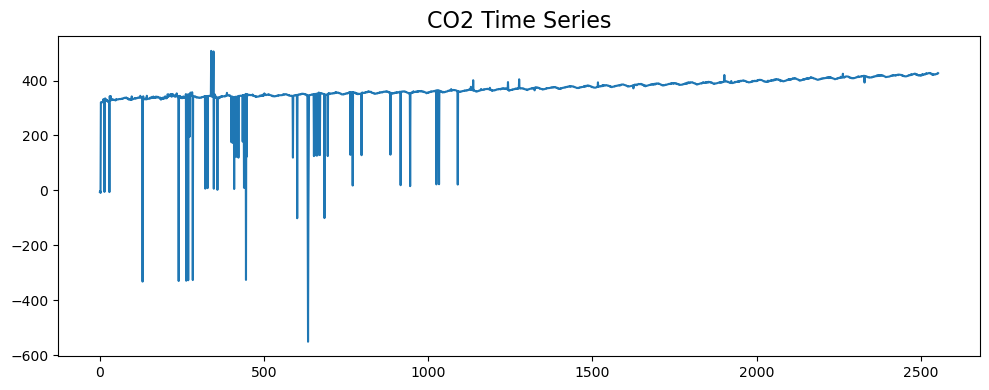

ADF and KPSS tests for CO2:
ADF statistic -2.9368
ADF p-value 0.0412
ADF critical values: {'1%': -3.4329424595562963, '5%': -2.862685339846278, '10%': -2.5673797079109892}

KPSS statistic 8.7714
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the CO2 time series may be difference-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_61996\1062959689.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


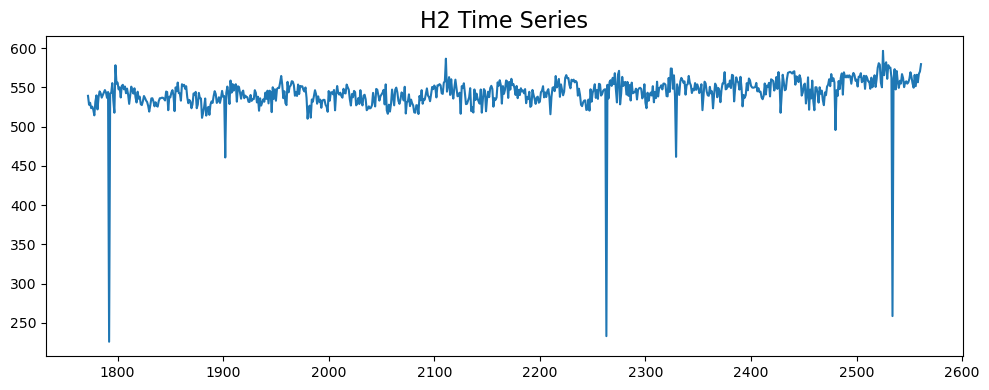

ADF and KPSS tests for H2:
ADF statistic -9.2911
ADF p-value 0.0000
ADF critical values: {'1%': -3.438707722728768, '5%': -2.8652288644673125, '10%': -2.568734303622865}

KPSS statistic 2.8829
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the H2 time series may be difference-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_61996\1062959689.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


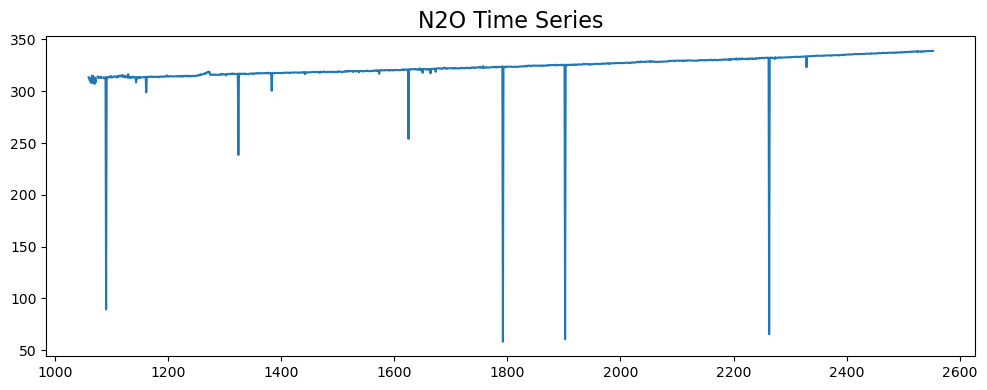

ADF and KPSS tests for N2O:
ADF statistic -2.6282
ADF p-value 0.0873
ADF critical values: {'1%': -3.434815425568625, '5%': -2.8635121913888306, '10%': -2.567819976000063}

KPSS statistic 5.9138
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the N2O time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_61996\1062959689.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


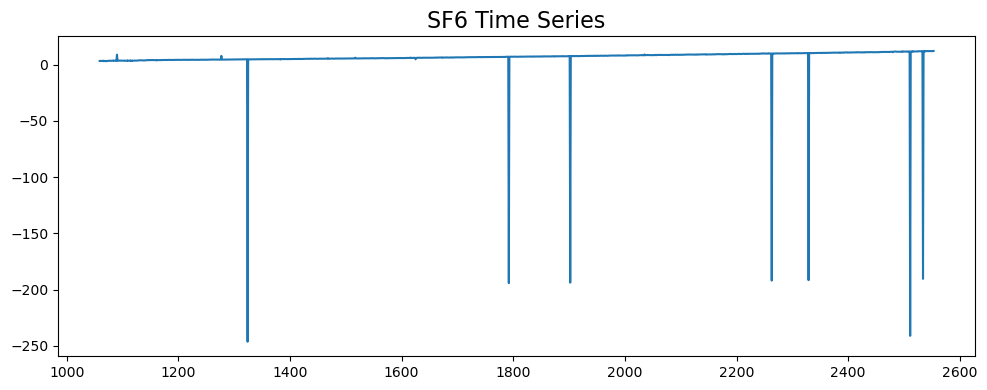

ADF and KPSS tests for SF6:
ADF statistic -6.1889
ADF p-value 0.0000
ADF critical values: {'1%': -3.434821532444398, '5%': -2.863514886524506, '10%': -2.5678214111987328}

KPSS statistic 2.1675
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the SF6 time series may be difference-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_61996\1062959689.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


In [13]:
# Run ADF and KPSS tests to determine if statistical properties, including mean, variance, and autocorrelation, 
# are stable (stationary) over time.  
# ADF - Augmented Dickey-Fuller test
# KPSS - Kwiatkowski-Phillips-Schmidt-Shin test

gas_columns = ['CH4','CO','CO2','H2','N2O','SF6']

# function to check stationarity
def check_stationarity(series, gas):
    adf_result = adfuller(series.dropna())
    kpss_result = kpss(series.dropna(), regression='c')

    print(f'ADF and KPSS tests for {gas}:')
    print(f'ADF statistic {adf_result[0]:.4f}')
    print(f'ADF p-value {adf_result[1]:.4f}')
    print(f'ADF critical values: {adf_result[4]}\n')
    
    print(f'KPSS statistic {kpss_result[0]:.4f}')
    print(f'KPSS p-value {kpss_result[1]:.4f}')
    print(f'KPSS critical values: {kpss_result[3]}\n')

    if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
        print(f'the {gas} time series is likely stationary according to ADF and KPSS tests.\n')
    elif adf_result[1] > 0.05 and kpss_result[1] < 0.05:
        print(f'the {gas} time series is non-stationary according to ADF and KPSS tests.\n')
    elif adf_result[1] > 0.05 and kpss_result[1] > 0.05:
        print(f'the {gas} time series may be trend-stationary according to ADF and KPSS tests.\n')
    else: 
        print(f'the {gas} time series may be difference-stationary according to ADF and KPSS tests.\n')

# plot raw data and perform the ADF test
for gas in gas_columns:
    plt.figure(figsize=(10,4))
    plt.plot(df_combined[gas], label=gas)
    plt.title(f'{gas} Time Series', fontsize=16)
    plt.tight_layout()
    plt.show()

    check_stationarity(df_combined[gas], gas)

The ADF and KPSS values strongly indicate non-stationarity for CH4, CO2, N2O, and SF6, which isn't surprsing considering the substantial upward trajectory of the gas concentrations over time observed in the long-term trend analysis as well as what is well known about the accumulation of these gases in the atmosphere. Furthermore, all raw data plots suggest seasonality, which is also a known quality of GHG concentration data.  Seasonality will present autocorrelation, which also leads to non-stationarity.  These datasets will need to be differenced to remove the upward trend and to stabilize the mean for fitting a SARIMA model.  

All data series, with the possible exception of CO, have significant spikes, which may be outliers. STL (seasonal trend decomposition with LOESS) will be used to detect and handle outliers. 

## Analyze Long-Term Trends

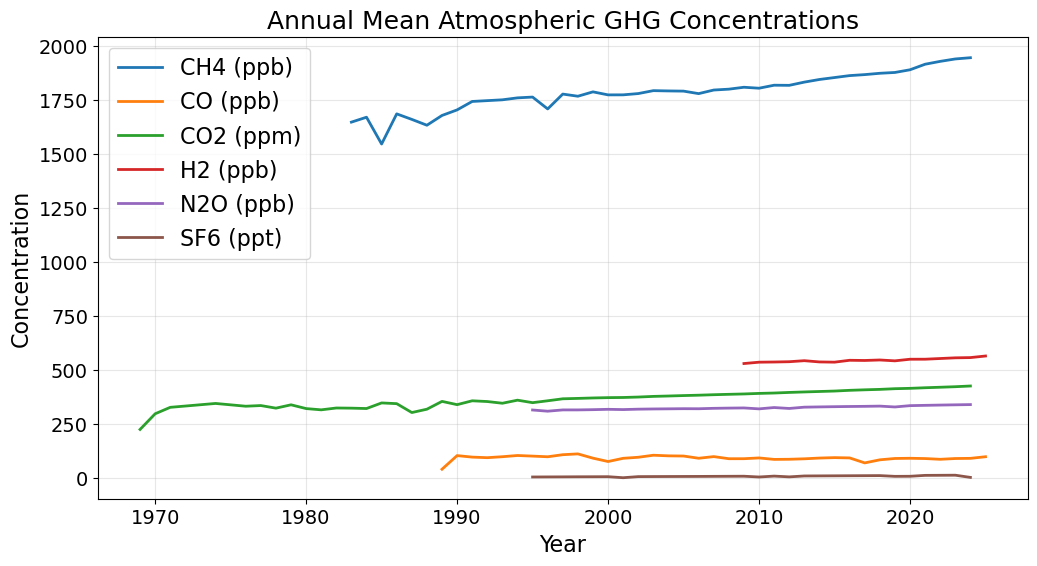

In [14]:
# plot the yearly average concentration values vs time to visualize the full trend of 
# atmospheric concentrations over time. 

# calculate yearly averages for each gas
df_combined['year'] = df_combined['date'].dt.year
yearly_avg_df = df_combined.groupby('year').mean(numeric_only=True)

unit_map = {
    'CH4' : 'ppb',
    'CO'  : 'ppb',
    'CO2' : 'ppm',
    'H2'  : 'ppb',
    'N2O' : 'ppb',
    'SF6' : 'ppt'
}

# plot
plt.figure(figsize=(12,6))
for gas in ['CH4','CO','CO2','H2','N2O','SF6']:
    label = f'{gas} ({unit_map[gas]})'
    plt.plot(yearly_avg_df.index, yearly_avg_df[gas], label=label, linewidth=2)

plt.title('Annual Mean Atmospheric GHG Concentrations', fontsize=18)
plt.ylabel('Concentration', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Create a data table of the linear regression metrics

gas_trend_data = []

gases = {
    'CH4': {'unit': 'ppb', 'scale':1},
    'CO': {'unit': 'ppb', 'scale':1},
    'CO2': {'unit': 'ppm', 'scale':1},
    'H2': {'unit': 'ppb', 'scale':1},
    'N2O': {'unit': 'ppb', 'scale':1},
    'SF6': {'unit': 'ppt', 'scale':1}
}

for gas in gases.keys():
    valid_data = yearly_avg_df[gas].dropna()
    x = valid_data.index
    y = valid_data.values

    # linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x,y)

    # calculate 95% confidence interval for the slope
    ci_low = slope - (1.96 * std_err)
    ci_high = slope + (1.96 * std_err)
    
    gas_trend_data.append({
        'Gas' : gas,
        'Slope' : f'{slope:.3f}',
        'Unit' : f'{gases[gas]['unit']}/yr',
        'R-sqrd' : f'{r_value**2:.3f}',
        'Std Err' : f'{std_err:.3f}',
        'p-val' : f'{p_value:.2e}',
        '95% CI Low' : f'{ci_low:.3f}',
        '95% CI high' : f'{ci_high:.3f}',
        'Start Yr' : x.min(),
        'End yr' : x.max()
    })

gas_trend_df = pd.DataFrame(gas_trend_data)
print(gas_trend_df.to_string(index=False))

Gas  Slope   Unit R-sqrd Std Err    p-val 95% CI Low 95% CI high  Start Yr  End yr
CH4  6.699 ppb/yr  0.895   0.363 3.53e-21      5.988       7.410      1983    2024
 CO -0.136 ppb/yr  0.015   0.186 4.70e-01     -0.500       0.228      1989    2025
CO2  2.321 ppm/yr  0.862   0.130 1.27e-23      2.066       2.575      1969    2024
 H2  1.706 ppb/yr  0.881   0.162 2.57e-08      1.388       2.024      2009    2025
N2O  0.894 ppb/yr  0.939   0.043 1.51e-18      0.810       0.978      1995    2024
SF6  0.202 ppt/yr  0.396   0.047 1.96e-04      0.109       0.294      1995    2024


**Gas Concentration Trend Linear Regression Summary**

All gases except CO show a statistically significant annual mean increase in atmospheric concentration.  CO2 has the greatest mean increase of 1.91 ppm/year, followed by CH4 at 6.7 ppb/year.  The data also corroborate a decrease in atmospheric CO concentrations due to cleaner combustion technologies and reduced emissions (https://earthobservatory.nasa.gov/images/149876/a-global-decline-in-carbon-monoxide).  

## Data Cycles and Frequency (per year)

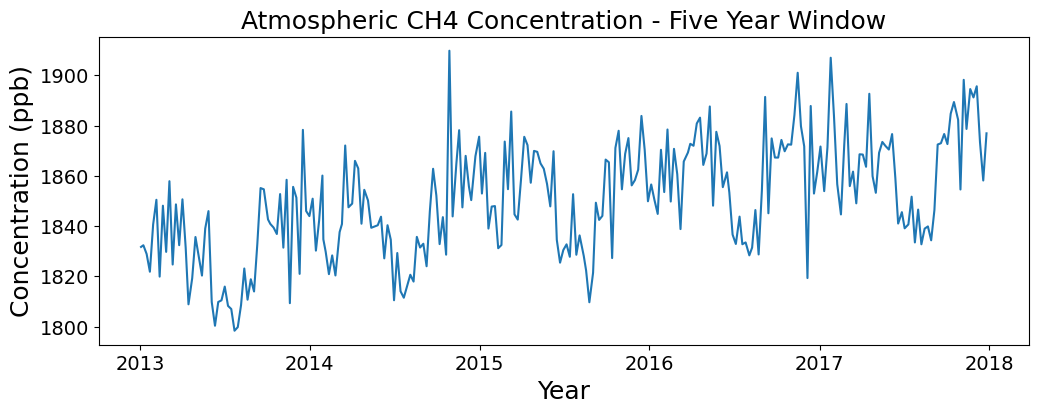

In [21]:
# visualize seasonal cycles in a subset of the full dataset.  
# I will use [CH4] values between the years of 2013 - 2018 to avoid spikes.  

mask = (df_combined['date'] >= '2013-01-01') & (df_combined['date'] <= '2018-01-01')
ch4_subset = df_combined.loc[mask, 'CH4']

plt.figure(figsize=(12,4))
plt.plot(df_combined.loc[mask, 'date'], ch4_subset, linewidth=1.5)
plt.title('Atmospheric CH4 Concentration - Five Year Window', fontsize = 18)
plt.ylabel('Concentration (ppb)', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

The yearly seasonality is apparent in all gas dataset plots and highlighted here for a subset of CH4 data as an example.  The increasing trend can also be observed in this 5 year window.  

In [17]:
# The seasonality appears as a single cycle per year for each gas. 
# Confirm the number of datapoints per year for each gas.

df_counts = df_combined.copy()

df_counts['year'] = df_counts['date'].dt.year # extract the year
yearly_counts = df_counts.groupby('year').count()
yearly_counts

,date,CH4,CO,CO2,H2,N2O,SF6
year,,,,,,,
1969,10,0,0,10,0,0,0
1970,21,0,0,21,0,0,0
1971,2,0,0,2,0,0,0
1974,1,0,0,1,0,0,0
1976,25,0,0,25,0,0,0
1977,47,0,0,47,0,0,0
1978,48,0,0,48,0,0,0
1979,52,0,0,52,0,0,0
1980,58,0,0,58,0,0,0


In [18]:
# As expected, there is variation in the number of data points per year.  
# I will determine and use the mode of each gas for signal decomposition, preprocessing, and modeling.

seasonal_mode = yearly_counts.replace(0, np.nan).mode().iloc[0] 
seasonal_mode

date    52.0
CH4     52.0
CO      52.0
CO2     52.0
H2      52.0
N2O     52.0
SF6     52.0
Name: 0, dtype: float64

The yearly mode for each data series is 52, which means that the data is generally collected weekly.  